In [1]:
# Import libraries

import numpy as np
import sqlite3
import pandas as pd
import geopandas as gpd
import json
from shapely import wkt
from shapely import MultiPoint
from shapely.geometry import Polygon, Point
import calendar
import matplotlib.pyplot as plt

db_location = 'C:/Users/Andras/Documents/GitHub/DataSystemsProjectG5/Code/data/AMS_data.sqlite'
import streamlit as st

In [2]:
# Import CBS grid data for AMSTERDAM

# Load data from SQLite database
with sqlite3.connect(db_location) as conn:
    ams_grid = pd.read_sql('SELECT geometry FROM "CBS Amsterdam"', conn)
    ams_boundaries = pd.read_sql('SELECT "geometrie.type","geometrie.coordinates" FROM "residential areas"', conn)
    
ams_grid['geometry'] = ams_grid['geometry'].apply(wkt.loads)
ams_grid = gpd.GeoDataFrame(ams_grid, crs='epsg:28992')

ams_boundaries['geometry'] = ams_boundaries['geometrie.coordinates'].apply(lambda x: Polygon(json.loads(x)[0]))
ams_boundaries = gpd.GeoDataFrame(ams_boundaries['geometry'], crs='epsg:28992')
amsterdam_resid = ams_boundaries.dissolve().values[0][0]

In [3]:
# Create new grid covering entire region

# Grid dimensions
grid_resolution_x = 100  # metres
grid_resolution_y = 100  # metres

# Create grid in geometry format
xmin, ymin, xmax, ymax = ams_grid.total_bounds

expanded_grid_blocks = []
x_boundaries = np.arange(xmin, xmax, grid_resolution_x)
y_boundaries = np.arange(ymin, ymax, grid_resolution_y)

for i, x in enumerate(x_boundaries):
    for j, y in enumerate(y_boundaries):

        block = Polygon([
            (x,y), 
            (x+grid_resolution_x, y),
            (x+grid_resolution_x, y+grid_resolution_y),
            (x, y+grid_resolution_y)])
        expanded_grid_blocks.append(block)
        
new_grid = gpd.GeoDataFrame({'geometry':expanded_grid_blocks}, crs='epsg:28992')
new_ams = new_grid[new_grid.within(amsterdam_resid)].copy()

In [4]:
# Calculate building density on grid
# Load data
with sqlite3.connect(db_location) as conn:
    trees = pd.read_sql('SELECT boomhoogteklasseActueel,jaarVanAanleg,soortnaamKort,"geometrie.coordinates" FROM "trees"', conn)
    buildings = pd.read_sql('SELECT oorspronkelijkBouwjaar,statusOmschrijving,"geometrie.coordinates" FROM "buildings"', conn)

buildings['geometrie.coordinates'] = buildings['geometrie.coordinates'].apply(lambda x: json.loads(x))
buildings = buildings.dropna(subset=['geometrie.coordinates'])
buildings['geometry'] = buildings['geometrie.coordinates'].apply(lambda x: Polygon(x[0]))
buildings = gpd.GeoDataFrame(buildings.drop(columns=['geometrie.coordinates']), crs='epsg:28992')

# Fix building year issue
buildings['oorspronkelijkBouwjaar'] = buildings['oorspronkelijkBouwjaar'].replace({1005:1900})

In [5]:
# Calculate tree density on grid

trees['geometrie.coordinates'] = trees['geometrie.coordinates'].apply(lambda x: json.loads(x))
trees = trees.dropna(subset=['geometrie.coordinates'])
trees['geometry'] = trees['geometrie.coordinates'].apply(lambda xy: Point(xy))
trees = gpd.GeoDataFrame(trees.drop(columns=['geometrie.coordinates']), crs='epsg:28992')

height_class = {
    'ZZ_Vervallen 12 tot 18 m.' : np.nan, 
    'ZZ_Vervallen 6 tot 12 m.' : np.nan,
    'ZZ_Vervallen Onbekend' : np.nan, 
    'a. tot 6 m.' : 0.5, 
    'b. 6 tot 9 m.' : 1,
    'c. 9 tot 12 m.' : 1.5, 
    'd. 12 tot 15 m.' : 2, 
    'e. 15 tot 18 m.' : 2.5,
    'f. 18 tot 24 m.' : 3, 
    'g. 24 m. en hoger' : 3.5, 
    'q. Niet van toepassing' : np.nan,
    None : np.nan}

trees['height_class'] = trees['boomhoogteklasseActueel'].replace(height_class)
trees = trees.dropna(subset=['height_class'])
trees['age'] = 2024-trees["jaarVanAanleg"]

new_ams['trees'] =  new_ams['geometry'].apply(lambda x: trees[trees.within(x)]['height_class'].sum())
new_ams['tree_age'] =  new_ams['geometry'].apply(lambda x: trees[trees.within(x)]['age'].median())

In [7]:
from shapely import unary_union

grid_cells = new_ams['geometry'].reset_index(drop=True)
building_cells = buildings[buildings['statusOmschrijving']=='Pand in gebruik'][['geometry','oorspronkelijkBouwjaar']].reset_index(drop=True)
building_cells['age'] = 2023 - building_cells['oorspronkelijkBouwjaar']

grids_with_polygons = gpd.sjoin(left_df=grid_cells.to_frame(), right_df=building_cells, how='inner')

building_area_per_block = np.zeros(len(grid_cells))
average_age_per_block = np.zeros(len(grid_cells))

for pos in grids_with_polygons.index.unique():
    
    buildings_in_pos = building_cells.loc[ grids_with_polygons.loc[[pos], 'index_right']]
    join_buildings = unary_union(buildings_in_pos['geometry'])
    area = join_buildings.intersection(grid_cells.loc[pos]).area
    building_area_per_block[pos] = area
    
    buildings_in_pos['area'] = buildings_in_pos['geometry'].map(lambda x: x.intersection(grid_cells.loc[pos]).area )
    average_age_per_block[pos] = np.average(buildings_in_pos['age'], weights=buildings_in_pos['area'])

new_ams['building_area'] = building_area_per_block / (grid_resolution_x*grid_resolution_y)
new_ams['average_building_age'] = average_age_per_block

reduced_amsgrid = new_ams[ (new_ams['building_area']>0) | (new_ams['trees']>0) ]

In [17]:
new_ams.head()

,geometry,trees,tree_age,building_area,average_building_age
130,"POLYGON ((111400.000 490300.000, 111500.000 49...",0.0,NaN,0.000000,0.0
131,"POLYGON ((111400.000 490400.000, 111500.000 49...",0.0,NaN,0.001720,25.0
132,"POLYGON ((111400.000 490500.000, 111500.000 49...",0.0,NaN,0.033969,25.0
133,"POLYGON ((111400.000 490600.000, 111500.000 49...",0.0,NaN,0.000000,0.0
134,"POLYGON ((111400.000 490700.000, 111500.000 49...",0.0,NaN,0.000000,0.0


In [8]:
def count_high_winds(series):
    return (series > 15).sum()
def sum_precipitation(series):
    return series.sum()
def avg_wind(series):
    return series.mean()
def leaves_on(x):
    if x in ['October','November', 'December','January', 'February', 'March']:
        return 0
    else:
        return 1

In [9]:
# Combine incidents with weather data
from pandas.api.types import CategoricalDtype
cat_type_dir = CategoricalDtype(categories=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], ordered=False)
cat_type_hour = CategoricalDtype(categories=range(24), ordered=False)
cat_type_month = CategoricalDtype(categories=[calendar.month_name[i+1] for i in range(12)], ordered=False)

# Load weather and incident data
with sqlite3.connect(db_location) as conn:
    weather = pd.read_sql('SELECT * FROM "WeatherDataH"', conn)
    incidents = pd.read_sql('SELECT * FROM "Incidents"', conn)

weather['Wind direction (degrees)'] = weather['Wind direction (degrees)'].replace({360:0,990:200})
weather['Wind direction (direction)'] = pd.cut(weather['Wind direction (degrees)'], 
                                        bins=np.append(np.insert(np.arange(0,360,45)+22.5,0,0),360),
                                        ordered=False, 
                                        labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']).astype(cat_type_dir)           

month_dict = dict(zip(range(1,13), calendar.month_name[1:]))
weather['month'] = pd.to_datetime(weather['Date'], format='%Y%m%d').dt.month.replace(month_dict).astype(cat_type_month)
weather['Hour'] = weather['Hour'].replace({24:0}).astype(cat_type_hour)
weather['Hourly precipitation amount (mm)'] = weather['Hourly precipitation amount (mm)'].replace({-0.01 : 0.00})
weather['Precipitation past week'] = weather['Hourly precipitation amount (mm)'].rolling(window=168).apply(sum_precipitation)
weather['Strong wind past two days'] = weather['Average hourly wind speed (m/s)'].rolling(window=48).apply(count_high_winds)
weather['Average wind past two days'] = weather['Average hourly wind speed (m/s)'].rolling(window=48).apply(avg_wind)
weather['Max wind past day'] = weather['Maximum hourly wind speed (m/s)'].rolling(window=24).apply(max)
weather['Leaves on or not'] = weather['month'].apply(leaves_on)
weather['Snowy hours past day'] = weather['Snow'].rolling(window=24).apply(sum_precipitation)

incidents['geometry'] = gpd.points_from_xy(incidents['LON'], incidents['LAT'])
incidents = gpd.GeoDataFrame(incidents, crs='epsg:4326', geometry='geometry')
incidents = incidents.to_crs('epsg:28992')
    
incidents['date_int'] = pd.to_datetime(incidents['Date']).dt.strftime("%Y%m%d").astype('int64')
incidents['hour_int'] = pd.to_datetime(incidents['Incident_Starttime'], format="%H:%M:%S.%f").dt.hour.astype(cat_type_hour)
incidents['month'] = pd.to_datetime(incidents['Date']).dt.month.replace(month_dict).astype(cat_type_month)

incidents_weather = incidents.merge(weather, how='left', left_on=['date_int', 'hour_int', 'month'], right_on=['Date','Hour','month'])

all_data = gpd.sjoin(left_df=incidents_weather, right_df=reduced_amsgrid, how='left').dropna(subset=['building_area', 'trees'])

In [10]:
weather_day = weather.groupby("Date").agg({"Hourly precipitation amount (mm)":"sum",
                                           "Average hourly wind speed (m/s)":"mean",
                                           "Maximum hourly wind speed (m/s)":"max"}).reset_index()
weather_day['month'] = pd.to_datetime(weather_day['Date'], format='%Y%m%d').dt.month.replace(month_dict).astype(cat_type_month)
weather_day['Precipitation past two week'] = weather_day["Hourly precipitation amount (mm)"].rolling(14).sum()
weather_day['Average wind past three days'] = weather_day["Average hourly wind speed (m/s)"].rolling(3).mean()
weather_day['Leaves on or not'] = weather_day["month"].apply(leaves_on)
weather_day.replace({"Maximum hourly wind speed (m/s)":"Max wind past day"},inplace=True)
weather_day.tail()

,Date,Hourly precipitation amount (mm),Average hourly wind speed (m/s),Maximum hourly wind speed (m/s),month,Precipitation past two week,Average wind past three days,Leaves on or not
6879,20231102,12.3,12.125000,25,November,113.6,7.625000,0
6880,20231103,15.7,8.958333,18,November,113.0,9.291667,0
6881,20231104,3.6,6.958333,13,November,107.1,9.347222,0
6882,20231105,8.3,6.833333,19,November,110.2,7.583333,0
6883,20231106,1.2,7.791667,16,November,106.5,7.194444,0


In [11]:
incidents_weather_day = incidents.merge(weather_day, how='left', left_on=['date_int', 'month'], right_on=['Date','month'])
all_data = gpd.sjoin(left_df=incidents_weather_day, right_df=reduced_amsgrid, how='left').dropna(subset=['building_area', 'trees'])
all_data

,Incident_ID,Date_x,Incident_Starttime,Incident_Endtime,Incident_Duration,Incident_Priority,Service_Area,Municipality,Damage_Type,LON,...,Average hourly wind speed (m/s),Maximum hourly wind speed (m/s),Precipitation past two week,Average wind past three days,Leaves on or not,index_right,trees,tree_age,building_area,average_building_age
1,738,2018-09-10 00:00:00,16:46:38.000000,18:00:55.000000,01:14:17.000000,2.0,Victor,Amsterdam,Tree,4.930968,...,5.166667,12,74.4,5.027778,1,19835.0,51.5,32.5,0.220139,74.530802
2,739,2018-09-10 00:00:00,17:11:20.000000,18:01:00.000000,00:49:40.000000,2.0,Dirk,Amsterdam,Building,4.898818,...,5.166667,12,74.4,5.027778,1,16356.0,9.0,34.0,0.490913,134.499068
3,1335,2018-09-18 00:00:00,19:17:33.000000,20:41:29.000000,01:23:56.000000,2.0,Zebra,Amsterdam,"Fence, Road signs, Scaffolding",4.960809,...,7.125000,17,69.4,5.027778,1,23031.0,13.5,2024.0,0.217479,17.946179
5,1502,2018-09-21 00:00:00,08:29:22.000000,10:06:43.000000,01:37:21.000000,2.0,Dirk,Amsterdam,Building,4.870656,...,11.083333,25,5.0,8.097222,1,13352.0,31.0,49.0,0.412663,121.856926
6,1502,2018-09-21 00:00:00,08:29:22.000000,10:06:43.000000,01:37:21.000000,2.0,Dirk,Amsterdam,Tree,4.870656,...,11.083333,25,5.0,8.097222,1,13352.0,31.0,49.0,0.412663,121.856926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731,443472,2023-11-02 00:00:00,19:45:17.000000,20:27:36.000000,00:42:19.000000,2.0,Willem,Amsterdam,Tree,4.908217,...,12.125000,25,113.6,7.625000,0,17271.0,17.0,39.0,0.000191,16.000000
5732,443474,2023-11-02 00:00:00,19:53:02.000000,23:41:51.000000,03:48:49.000000,2.0,Pieter,Amsterdam,Tree,4.822130,...,12.125000,25,113.6,7.625000,0,7966.0,32.5,43.0,0.163422,30.288827
5733,443476,2023-11-02 00:00:00,20:00:19.000000,20:52:15.000000,00:51:56.000000,2.0,Osdorp,Amsterdam,Tree,4.787237,...,12.125000,25,113.6,7.625000,0,4355.0,100.0,14.0,0.034960,47.879723
5734,443481,2023-11-02 00:00:00,20:22:54.000000,20:29:42.000000,00:06:48.000000,5.0,IJsbrand,Amsterdam,Tree,4.882178,...,12.125000,25,113.6,7.625000,0,14684.0,71.0,49.0,0.156956,95.442410


In [68]:
weathercolumns = [
    'Date',
    'Leaves on or not',
    'Maximum hourly wind speed (m/s)',
    'Precipitation past two week',
    'Average wind past three days']

gridcolumns = [
    'geometry',
    'building_area',
    'average_building_age',
    'trees',
    'tree_age']

number_negatives=10000

In [69]:
unique_dates = all_data['date_int'].unique()
filtered_daily_weather = weather_day[weather_day['Date'].isin(unique_dates)]
randomweather = filtered_daily_weather.sample(10000, replace=True)
randomgrids = reduced_amsgrid.sample(10000, replace=True)
negatives = pd.concat([randomweather[weathercolumns].reset_index(drop=True), randomgrids[gridcolumns].reset_index(drop=True)], axis=1)
negatives = negatives[~negatives.set_index(['Date', 'geometry']).index.isin(all_data.set_index(['date_int', 'geometry']).index)]
selected_data = negatives.sample(int(number_negatives/2), replace=False).drop(columns=['Date', 'geometry', 'tree_age'])
selected_data['event']=0

In [70]:
selected_data.head()

,Leaves on or not,Maximum hourly wind speed (m/s),Precipitation past two week,Average wind past three days,building_area,average_building_age,trees,event
6582,1,17,24.5,4.611111,0.000000,0.000000,4.0,0
2603,0,17,36.5,5.972222,0.478062,228.967444,16.5,0
5044,1,10,42.5,4.041667,0.173905,34.441189,6.5,0
9697,1,12,44.1,7.055556,0.262678,41.000000,71.5,0
4474,0,10,28.5,4.041667,0.206105,57.784078,15.0,0


In [71]:
import random

# Create training set

weather_columns = [
#    'month', 
#    'Wind direction (direction)', 
#    'Snowy hours past day',
    'Leaves on or not',
    #'Average hourly wind speed (m/s)', 
    'Maximum hourly wind speed (m/s)',
    'Precipitation past two week',
    #'Strong wind past two days',
    'Average wind past three days']
    #'Max wind past day'

grid_columns = [
    'building_area',
    'average_building_age',
    'trees']

positive_examples_tree = all_data[all_data['Damage_Type'].isin(['Tree','Fence, Road signs, Scaffolding', 'Unknown'])][weather_columns+grid_columns].dropna().copy()
positive_examples_tree['event'] = 1

positive_examples_building = all_data[all_data['Damage_Type'].isin(['Building','Fence, Road signs, Scaffolding', 'Unknown'])][weather_columns+grid_columns].dropna().copy()
positive_examples_building['event'] = 1

random_weather = weather_day.sample(int(number_negatives/2), replace=True)
random_grids = reduced_amsgrid.sample(int(number_negatives/2), replace=True)

negative_examples = pd.concat([random_weather[weather_columns].reset_index(drop=True), random_grids[grid_columns].reset_index(drop=True)], axis=1)
negative_examples['event'] = 0

train_data_tree = pd.concat([positive_examples_tree, negative_examples, selected_data])
train_data_building = pd.concat([positive_examples_building, negative_examples, selected_data])

duplicates_tree = train_data_tree.duplicated(subset=train_data_tree.columns.difference(['event']), keep='first')
train_data_tree = train_data_tree[~((train_data_tree['event']==0) & (duplicates_tree))]

duplicates_building = train_data_building.duplicated(subset=train_data_building.columns.difference(['event']), keep='first')
train_data_building = train_data_building[~((train_data_building['event']==0) & (duplicates_building))]

#for column in ['month']:
#
#    train_data_tree = pd.concat([train_data_tree, pd.get_dummies(train_data_tree[column])], axis=1)
#    train_data_tree = train_data_tree.drop(columns=[column])
#    train_data_building = pd.concat([train_data_building, pd.get_dummies(train_data_building[column])], axis=1)
#    train_data_building = train_data_building.drop(columns=[column])

train_data_tree.columns = train_data_tree.columns.astype(str)
train_data_tree[train_data_tree['average_building_age']>300]['average_building_age'] = 300
train_data_tree[train_data_tree['trees']>200]['trees'] = 200

train_data_building.columns = train_data_building.columns.astype(str)
train_data_building[train_data_building['average_building_age']>300]['average_building_age'] = 300
train_data_building[train_data_building['trees']>200]['trees'] = 200


Y_tree=train_data_tree['event']
X_tree = train_data_tree.drop(columns=['event', 'building_area', 'average_building_age'])
Y_building=train_data_building['event']
X_building = train_data_building.drop(columns=['event', 'trees'])


C:\Users\Andras\AppData\Local\Temp\ipykernel_16996\1088380069.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_tree[train_data_tree['average_building_age']>300]['average_building_age'] = 300
C:\Users\Andras\AppData\Local\Temp\ipykernel_16996\1088380069.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_tree[train_data_tree['trees']>200]['trees'] = 200
C:\Users\Andras\AppData\Local\Temp\ipykernel_16996\1088380069.py:55: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

In [73]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_tree, Y_tree, test_size=0.2, stratify=Y_tree, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_building, Y_building, test_size=0.2, stratify=Y_building, random_state=42)

In [74]:
from xgboost import XGBClassifier
from scipy.sparse import lil_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler


# Calculate the imbalance ratio
imbalance_ratio_t = sum(y_train_t == 0) / sum(y_train_t == 1)
imbalance_ratio_b = sum(y_train_b == 0) / sum(y_train_b == 1)

building_pipeline = Pipeline([('xgb_model', XGBClassifier(objective='binary:logistic'))])
tree_pipeline = Pipeline([('xgb_model', XGBClassifier(objective='binary:logistic'))])
logistic_tree = Pipeline([('scaler', StandardScaler()), ('clf_log', LogisticRegression())])
logistic_building = Pipeline([('scaler', StandardScaler()), ('clf_log', LogisticRegression())])
rf_tree = Pipeline([('scaler', StandardScaler()), ('clf_rf', RandomForestClassifier())])
rf_building=Pipeline([('scaler', StandardScaler()), ('clf_rf', RandomForestClassifier())])

# Assuming X_train_t and y_train_t are DataFrames or Series
Xy_train_t_no_nan = pd.concat([X_train_t, y_train_t], axis=1).dropna()
Xy_train_b_no_nan = pd.concat([X_train_b, y_train_b], axis=1).dropna()
# Separate the features and target variable again
X_train_t_no_nan = Xy_train_t_no_nan.drop(columns=['event'])
y_train_t_no_nan = Xy_train_t_no_nan['event']
X_train_b_no_nan = Xy_train_b_no_nan.drop(columns=['event'])
y_train_b_no_nan = Xy_train_b_no_nan['event']

# Assuming X_train_t and y_train_t are DataFrames or Series
Xy_test_t_no_nan = pd.concat([X_test_t, y_test_t], axis=1).dropna()
Xy_test_b_no_nan = pd.concat([X_test_b, y_test_b], axis=1).dropna()
# Separate the features and target variable again
X_test_t_no_nan = Xy_test_t_no_nan.drop(columns=['event'])
y_test_t_no_nan = Xy_test_t_no_nan['event']
X_test_b_no_nan = Xy_test_b_no_nan.drop(columns=['event'])
y_test_b_no_nan = Xy_test_b_no_nan['event']


oversampler = RandomOverSampler(random_state=42)
X_train_resampled_t, y_train_resampled_t= oversampler.fit_resample(X_train_t, y_train_t)
X_train_resampled_b, y_train_resampled_b= oversampler.fit_resample(X_train_b, y_train_b)

tree_pipeline.fit(X_train_t, y_train_t)
building_pipeline.fit(X_train_b, y_train_b)



logistic_tree.fit(X_train_t_no_nan, y_train_t_no_nan)
rf_tree.fit(X_train_t_no_nan, y_train_t_no_nan)
logistic_building.fit(X_train_b_no_nan, y_train_b_no_nan)
rf_building.fit(X_train_b_no_nan, y_train_b_no_nan)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf_rf', RandomForestClassifier())])

In [75]:
tree_probs = tree_pipeline.predict_proba(X_test_t)[:,1]
building_probs = building_pipeline.predict_proba(X_test_b)[:,1]
tree_log = logistic_tree.predict(X_test_t_no_nan)
building_log = logistic_building.predict(X_test_b_no_nan)
tree_rf = rf_tree.predict(X_test_t_no_nan)
building_rf = rf_building.predict(X_test_b_no_nan)

# Set a lower threshold
threshold = 0.5
preds_tree = (tree_probs > threshold).astype(int)
preds_building = (building_probs > threshold).astype(int)

Trees:
Accuracy: 0.8638
Precision: 0.7656
Recall: 0.6222
F1 Score: 0.6865
ROC AUC: 0.7811

Buildings:
Accuracy: 0.8859
Precision: 0.7888
Recall: 0.6536
F1 Score: 0.7148
ROC AUC: 0.8023

Confusion Matrices:
[[1879  120]
 [ 238  392]]
[[1901   98]
 [ 194  366]]


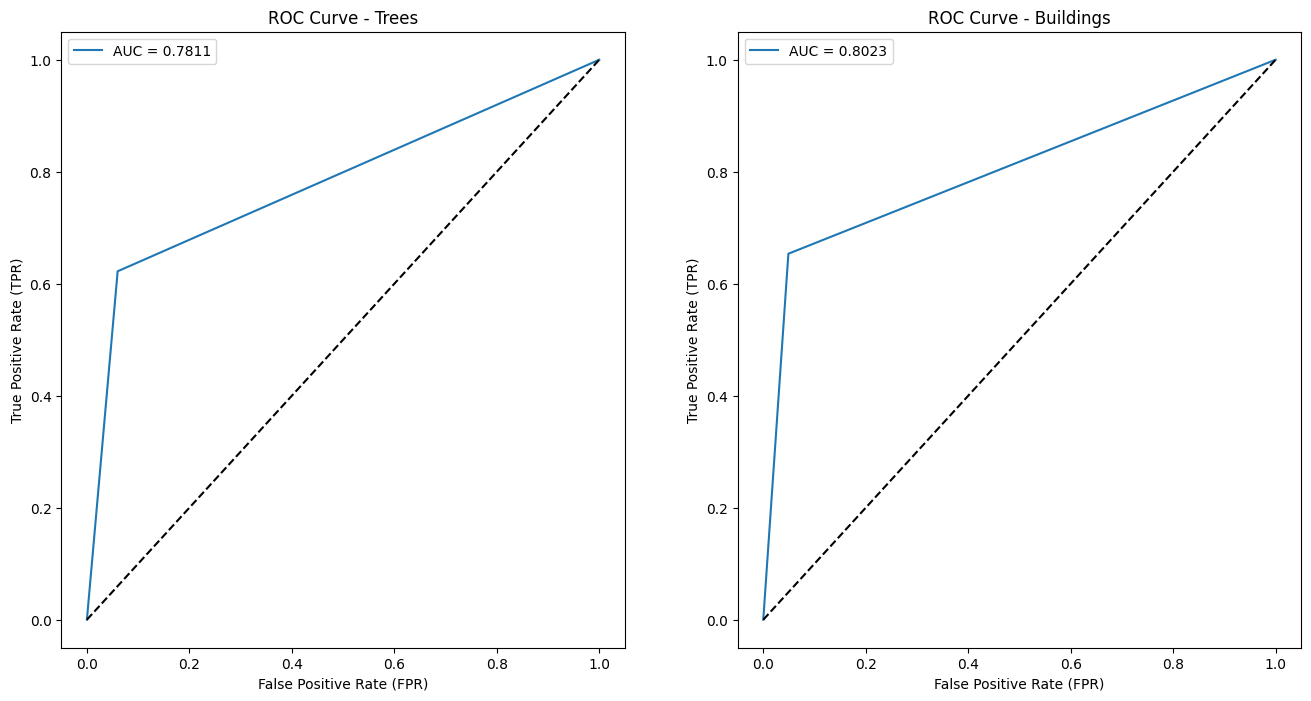

In [76]:
# Binary classification evaluation metrics
accuracy_t = accuracy_score(y_test_t, preds_tree)
precision_t = precision_score(y_test_t, preds_tree)
recall_t = recall_score(y_test_t, preds_tree)
f1_t = f1_score(y_test_t, preds_tree)
roc_auc_t = roc_auc_score(y_test_t, preds_tree)
accuracy_b = accuracy_score(y_test_b, preds_building)
precision_b = precision_score(y_test_b, preds_building)
recall_b = recall_score(y_test_b, preds_building)
f1_b = f1_score(y_test_b, preds_building)
roc_auc_b = roc_auc_score(y_test_b, preds_building)


print('Trees:')
print(f'Accuracy: {accuracy_t:.4f}')
print(f'Precision: {precision_t:.4f}')
print(f'Recall: {recall_t:.4f}')
print(f'F1 Score: {f1_t:.4f}')
print(f'ROC AUC: {roc_auc_t:.4f}\n')

print('Buildings:')
print(f'Accuracy: {accuracy_b:.4f}')
print(f'Precision: {precision_b:.4f}')
print(f'Recall: {recall_b:.4f}')
print(f'F1 Score: {f1_b:.4f}')
print(f'ROC AUC: {roc_auc_b:.4f}\n')

# Confusion Matrix
conf_matrix_t = confusion_matrix(y_test_t, preds_tree)
conf_matrix_b = confusion_matrix(y_test_b, preds_building)
print('Confusion Matrices:')
print(conf_matrix_t)
print(conf_matrix_b)

# ROC Curve
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, preds_tree)
fpr_b, tpr_b, thresholds_b = roc_curve(y_test_b, preds_building)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].plot(fpr_t, tpr_t, label=f'AUC = {roc_auc_t:.4f}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate (FPR)')
axes[0].set_ylabel('True Positive Rate (TPR)')
axes[0].set_title('ROC Curve - Trees')
axes[0].legend()

axes[1].plot(fpr_b, tpr_b, label=f'AUC = {roc_auc_b:.4f}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate (FPR)')
axes[1].set_ylabel('True Positive Rate (TPR)')
axes[1].set_title('ROC Curve - Buildings')
axes[1].legend()

plt.show()


In [99]:
accuracy = accuracy_score(y_test_b_no_nan, building_rf)
precision = precision_score(y_test_b_no_nan, building_rf)
recall = recall_score(y_test_b_no_nan, building_rf)

print(accuracy)
print(precision)
print(recall)

0.9011332551778038
0.8418708240534521
0.675


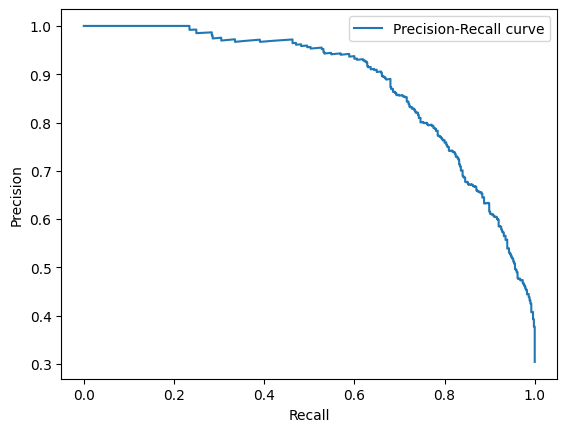

In [39]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

tree_probs = building_pipeline.predict_proba(X_test_b)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test_b, tree_probs)

plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

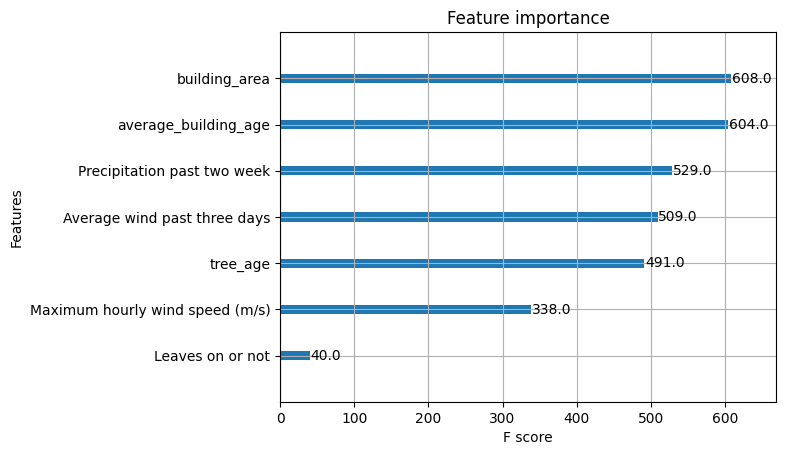

In [40]:
import xgboost as xgb
clf_event = XGBClassifier(objective='binary:logistic')
scaler_event=StandardScaler()
clf_event.fit(X_train_b, y_train_b)
#clf_event.fit(scaler_event.fit_transform(X_train_t), y_train_t)
xgb.plot_importance(clf_event, importance_type='weight', max_num_features=10)
plt.show()

In [34]:
import pickle

with open('xgb_building_pipeline_new.pickle', 'wb') as handle:
    pickle.dump(building_pipeline, handle)
    
with open('xgb_tree_pipeline_new.pickle', 'wb') as handle:
    pickle.dump(tree_pipeline, handle)

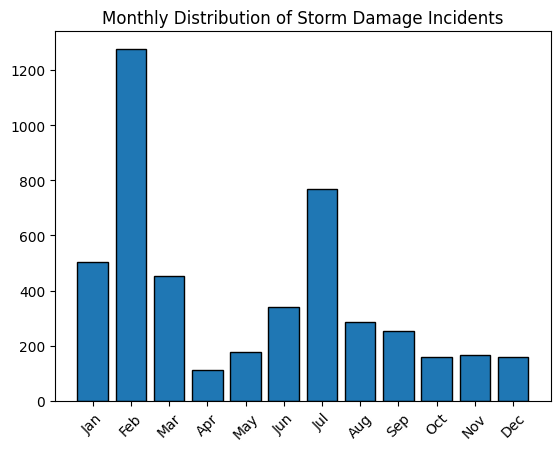

In [47]:
import calendar

# Assuming 'all_data' is your DataFrame

# Convert the 'date' column to datetime if it's not already
all_data['Date_x'] = pd.to_datetime(all_data['Date_x'])

# Extract month from the date column
all_data['month_x'] = all_data['Date_x'].dt.month

# Count occurrences of each month and sort by month
unique_months, counts = zip(*sorted(all_data['month_x'].value_counts().items()))

# Get month names in calendar order
month_names = [calendar.month_abbr[i] for i in unique_months]

# Plot the bar chart
plt.bar(month_names, counts, edgecolor='black')

# Set the x-axis ticks to the month names
plt.xticks(range(len(unique_months)), month_names, rotation=45, ha='center')
plt.title("Monthly Distribution of Storm Damage Incidents")

# Display the plot
plt.show()


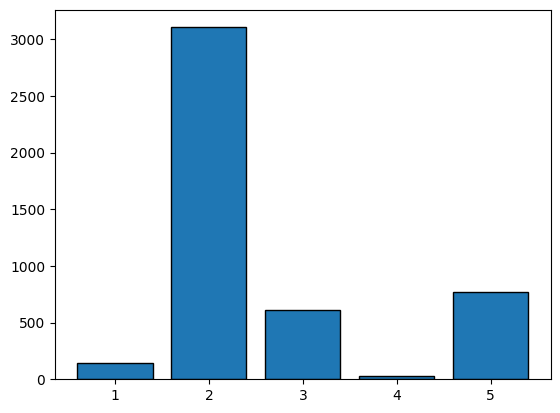

In [32]:
unique_prios, counts = zip(*sorted(all_data['Incident_Priority'].value_counts().items()))
plt.bar(unique_prios, counts, edgecolor='black')

plt.xticks(ha='center')

# Display the plot
plt.show()

c:\Users\Andras\anaconda3\envs\DSP\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


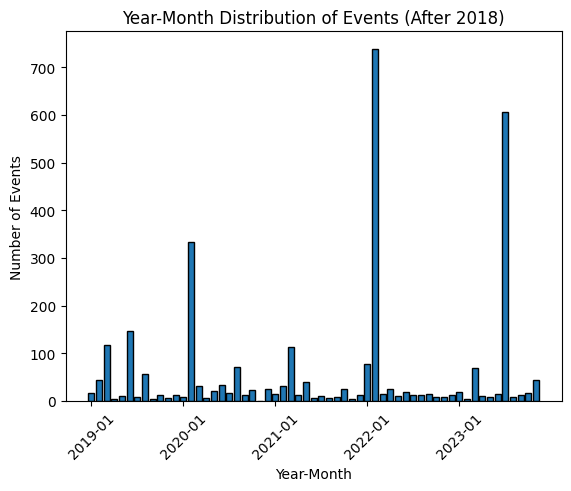

In [69]:
import calendar
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'all_data' is your DataFrame and it has a 'date' column
all_data['Date_x'] = pd.to_datetime(all_data['Date_x'])

# Filter events after 2018
all_data_after_2018 = all_data[all_data['Date_x'].dt.year > 2018]

# Extract year-month from the date column
all_data_after_2018['year_month'] = all_data_after_2018['Date_x'].dt.to_period('M')

# Count occurrences of each year-month and sort by year-month
unique_year_months, counts = zip(*sorted(all_data_after_2018['year_month'].value_counts().items()))

# Plot the bar chart
plt.bar(range(len(unique_year_months)), counts, edgecolor='black')

# Set the x-axis ticks to the year-month combinations for every 12th tick
ticks_positions = list(range(0, len(unique_year_months), 12))
plt.xticks(ticks_positions, [unique_year_months[i] for i in ticks_positions], rotation=45, ha='center')

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Number of Events')
plt.title('Year-Month Distribution of Events (After 2018)')

# Display the plot
plt.show()


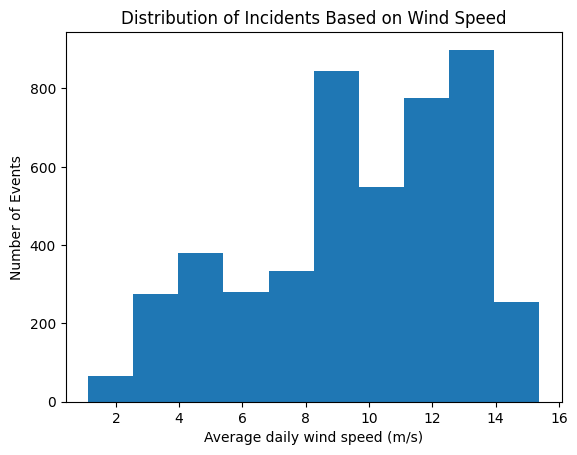

In [94]:
plt.hist(all_data['Average hourly wind speed (m/s)'])
# Set labels and title
plt.xlabel('Average daily wind speed (m/s)')
plt.ylabel('Number of Events')
plt.title('Distribution of Incidents Based on Wind Speed')
plt.show()

(array([ 113.,  174.,  165.,  333.,  120.,    0.,  524.,  848.,  608.,
        1770.]),
 array([12880. , 13558.3, 14236.6, 14914.9, 15593.2, 16271.5, 16949.8,
        17628.1, 18306.4, 18984.7, 19663. ]),
 <BarContainer object of 10 artists>)

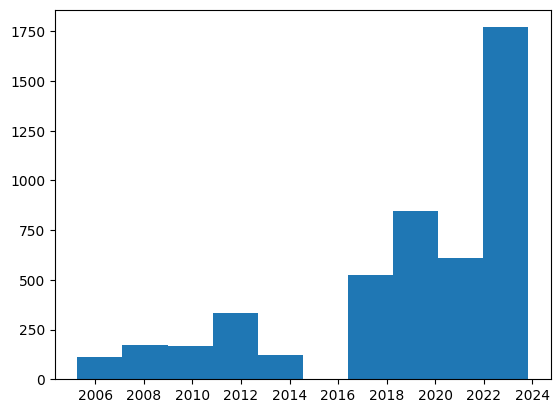

In [70]:
plt.hist(all_data['Date_x'])

(array([ 96.,  44.,  24.,  22.,  21.,  24.,  41.,  72., 217., 464., 473.,
        421., 422., 392., 356., 493., 551., 407., 386., 272., 200., 153.,
        111.,  75.]),
 array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
         4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
         9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
        14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
        19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]),
 <BarContainer object of 24 artists>)

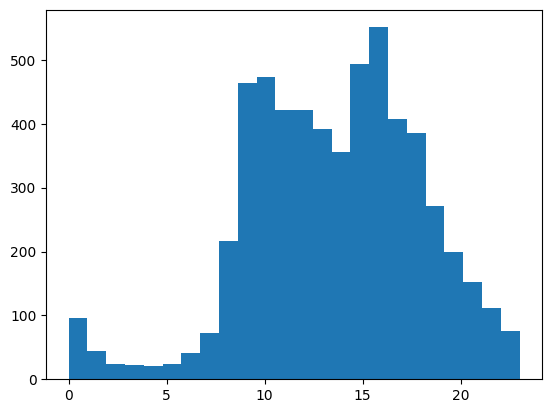

In [96]:
plt.hist(incidents['hour_int'], bins=24)

In [37]:
weather.tail()

,index,Station Number,Date,Hour,Wind direction (degrees),Average hourly wind speed (m/s),Average wind speed 10mins (m/s),Maximum hourly wind speed (m/s),Temperature (C),Minimum temperature 6hours (C),...,Indicator present weather code,Fog,Rainfall,Snow,Thunder,Ice formation,Wind direction (direction),month,Strong wind past two days,Precipitation past week
165211,165211,240,20231106,20,210,8,7,11,9.6,NaN,...,7,0.0,1.0,0.0,0.0,0.0,SW,November,0.0,70.6
165212,165212,240,20231106,21,210,7,7,10,9.8,NaN,...,7,0.0,1.0,0.0,0.0,0.0,SW,November,0.0,69.8
165213,165213,240,20231106,22,190,7,6,12,9.3,NaN,...,7,0.0,1.0,0.0,1.0,0.0,S,November,0.0,70.1
165214,165214,240,20231106,23,200,5,5,8,8.8,NaN,...,5,0.0,0.0,0.0,0.0,0.0,S,November,0.0,68.8
165215,165215,240,20231106,0,200,6,6,9,8.9,7.6,...,7,0.0,0.0,0.0,0.0,0.0,S,November,0.0,68.0


In [39]:
all_data.columns

Index(['Incident_ID', 'Date_x', 'Incident_Starttime', 'Incident_Endtime',
       'Incident_Duration', 'Incident_Priority', 'Service_Area',
       'Municipality', 'Damage_Type', 'LON', 'LAT', 'geometry', 'date_int',
       'hour_int', 'month', 'index', 'Station Number', 'Date_y', 'Hour',
       'Wind direction (degrees)', 'Average hourly wind speed (m/s)',
       'Average wind speed 10mins (m/s)', 'Maximum hourly wind speed (m/s)',
       'Temperature (C)', 'Minimum temperature 6hours (C)',
       'Dew point temperature (C)', 'Sunshine duration (uur)',
       'Global radiation (J/cm2)', 'Precipitation duration (uur)',
       'Hourly precipitation amount (mm)', 'Air pressure (hPa)',
       'Horizontal visibility', 'Cloud cover (in octants)',
       'Relative atmospheric humidity (percent)',
       'Present weather code (00-99)', 'Indicator present weather code', 'Fog',
       'Rainfall', 'Snow', 'Thunder', 'Ice formation',
       'Wind direction (direction)', 'index_right', 'trees', 'bui